Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Clean version](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/demos/demo10/demo10.ipynb)

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Modified in class](https://colab.research.google.com/drive/1SK47cU6k9u9iE8LmH5rtDVnz2eIlghDP?usp=sharing)

# Demo 10 - Network Analysis

[OSMnx](https://osmnx.readthedocs.io/en/stable/) - Python package for downloading and analyzing networks from OpenStreetMap (OSM)

In [ ]:
# Install OSMNX
!pip install osmnx

In [1]:
import os
import pandas as pd
import geopandas as gpd
import osmnx as ox

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the working directory
# # You will need to change this to your own folder on Google Drive
# os.chdir('/content/drive/MyDrive/Teaching/URSP688Y Spring 2024/demos/week10')

In [2]:
# Define coordinate systems
UTM18 = 26918
WGS84 = 4326

## Load a street network from OSM

In [4]:
# Retrieve the street network for Washington, DC
place = 'Washington, DC, USA'
dc_network_g = ox.graph_from_place(place, network_type='drive')
dc_network_g = ox.project_graph(dc_network_g, to_crs=UTM18)
# Convert to geodataframes for easy plotting and exploration
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

## Load other data

In [5]:
# Load affordable housing points
affordable_housing = gpd.read_file('affordable_housing.geojson').to_crs(UTM18)

In [6]:
# Load Metro Center point
metro_center = gpd.points_from_xy([-77.032774], [38.8985198])
metro_center = gpd.GeoDataFrame(geometry=metro_center, crs=WGS84).to_crs(epsg=UTM18)

<Axes: >

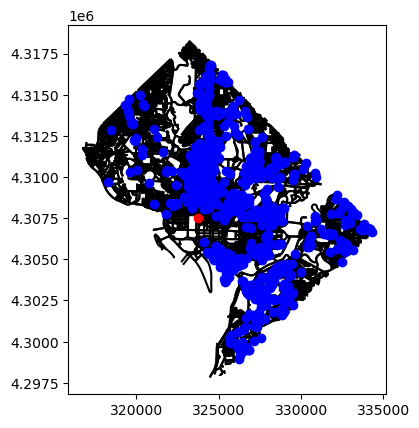

In [7]:
# Map data to make sure everything lines up
ax = dc_network_edges.plot(color='black', zorder=1)
affordable_housing.plot(ax=ax, color='blue', zorder=2)
metro_center.plot(ax=ax, color='red', zorder=3)

## Relate points to street network

In [8]:
# Find the nearest node to metro center
metro_center_nodes, metro_center_node_dists = ox.nearest_nodes(
    dc_network_g,
    metro_center.geometry.get_coordinates().x, 
    metro_center.geometry.get_coordinates().y, 
    return_dist=True)

In [9]:
metro_center_nodes

[49745629]

In [10]:
metro_center_node_dists

[74.35849321090423]

In [11]:
# Find the nearest nodes to affordable housing units
affordable_housing_nodes, affordable_housing_node_dists = ox.nearest_nodes(
    dc_network_g,
    affordable_housing.geometry.get_coordinates().x,
    affordable_housing.geometry.get_coordinates().y,
    return_dist=True)

In [12]:
affordable_housing_nodes[:5]

[49807765, 49763450, 49790538, 1472831067, 3661066113]

In [13]:
affordable_housing_node_dists[:5]

[33.91605174188366,
 44.405100455622225,
 54.892813796057176,
 56.58847166530133,
 80.40767204459081]

## Calculate shortest path

In [14]:
# Calculate shortest path
affordable_housing_node = affordable_housing_nodes[0]
metro_center_node = metro_center_nodes[0]

route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='length',
)

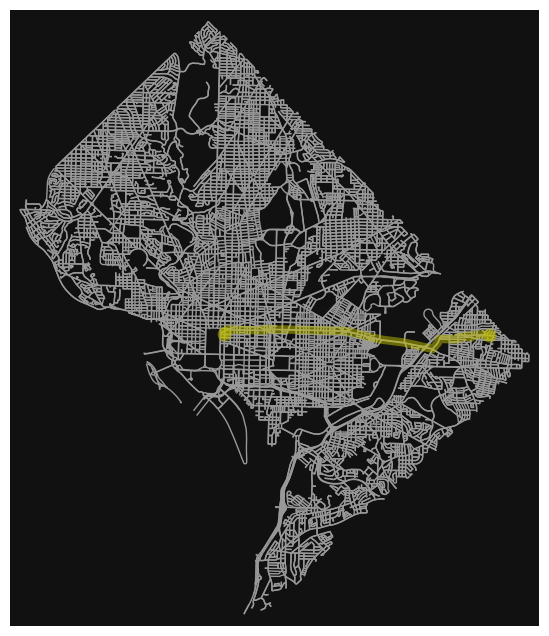

In [15]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

## Calculate travel time

In [17]:
# dc_network_edges.head()

In [18]:
# impute speed on all edges missing data
dc_network_g = ox.add_edge_speeds(dc_network_g)

# calculate travel time (seconds) for all edges
dc_network_g = ox.add_edge_travel_times(dc_network_g)

# Convert to geodataframes
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [19]:
route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='travel_time',
)

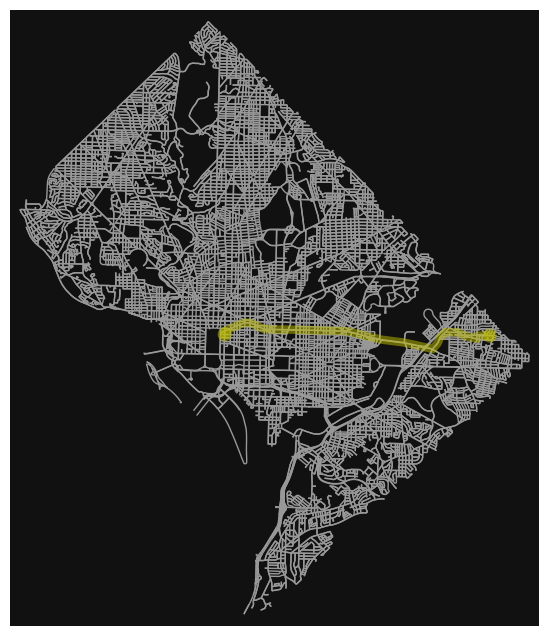

In [20]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

In [21]:
# Add up travel time and distance along the route
ox.routing.route_to_gdf(dc_network_g, route)['travel_time'].sum()

817.3000000000002

In [22]:
ox.routing.route_to_gdf(dc_network_g, route)['length'].sum()

9874.005000000001

## Loop calculations for bulk processing

In [30]:
def shortest_paths_to_metro_center(graph, o_nodes, d_node, weight='length'):    
    # Calculate shortest paths between each O-D pair
    d_nodes = [d_node] * len(o_nodes)
    routes = ox.shortest_path(graph, o_nodes, d_nodes, weight)
    # Gather data for edges along each route
    combined_route_edges = []
    for route_id, route in enumerate(routes):
        route_edges = ox.routing.route_to_gdf(dc_network_g, route)
        route_edges['route_id'] = route_id
        combined_route_edges.append(route_edges)
    combined_route_edges = pd.concat(combined_route_edges, axis=0)
    # Sum length and travel time for edges involved with each route
    route_summaries = combined_route_edges.groupby('route_id')[['length','travel_time']].sum()
    # Clean up column names
    route_summaries = route_summaries.rename(columns={'length':'dist_to_metro_center', 'travel_time': 'time_to_metro_center'})
    return route_summaries
        
routes = shortest_paths_to_metro_center(
    dc_network_g, 
    affordable_housing_nodes, 
    metro_center_node, 
    weight='length'
)

routes.head()

,dist_to_metro_center,time_to_metro_center
route_id,,
0,9791.881,826.5
1,8170.038,660.7
2,6907.320,611.5
3,11188.055,952.0
4,8522.920,728.7


In [36]:
# Add distance and time estimates back to affordable housing df
affordable_housing = pd.concat([affordable_housing, routes], axis=1)

In [37]:
affordable_housing.head()

,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,...,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry,dist_to_metro_center,time_to_metro_center
0,95907,Ward 7,"5201 Hayes Street Northeast, Washington, Distr...",5201 Hayes Street (Deanwood Hills),Completed 2015 to Date,DMPED DCHFA DHCD OP,150,38.899430,-76.926651,40,...,0,15-10,299817,406362.59,136844.61,5201 HAYES STREET NE,2024-03-25 09:00:28+00:00,POINT (332924.776 4307381.522),9791.881,826.5
1,95908,Ward 3,"5333 Connecticut Ave NW, Washington, District ...",5333 Connecticut Ave NW,Completed 2015 to Date,DHCD,19,38.960674,-77.072513,0,...,0,None,310383,393712.05,143635.35,5333 CONNECTICUT AVENUE NW,2024-03-25 09:00:28+00:00,POINT (320426.040 4314448.307),8170.038,660.7
2,95909,Ward 4,"5741 Colorado Avenue Northwest, Washington, Di...",5741 Colorado Avenue NW Tenant Association,Completed 2015 to Date,DHCD,35,38.959500,-77.030184,2,...,0,None,257860,397383.88,143510.74,5741 COLORADO AVENUE NW,2024-03-25 09:00:28+00:00,POINT (324094.387 4314243.109),6907.320,611.5
3,95910,Ward 7,"323 62nd Street Northeast, Washington, Distric...",62nd Street Apartments (w/ PADD) - Phase II (a...,Completed 2015 to Date,DCHFA DHCD,39,38.893744,-76.911893,0,...,0,None,310426,407639.84,136228.94,323 62ND STREET NE,2024-03-25 09:00:28+00:00,POINT (334188.208 4306738.004),11188.055,952.0
4,95911,Ward 4,"6925 Georgia Avenue Northwest, Washington, Dis...",6925-6929 Georgia Avenue,Completed 2015 to Date,DMPED DCHA DHCD,27,38.974276,-77.026519,8,...,0,None,243489,397702.01,145150.91,6925 GEORGIA AVENUE NW,2024-03-25 09:00:28+00:00,POINT (324448.466 4315875.944),8522.920,728.7


## Compare to straight line distance

In [47]:
affordable_housing['straight_dist_to_metro_center'] = affordable_housing.distance(metro_center.geometry.iloc[0])

<Axes: >

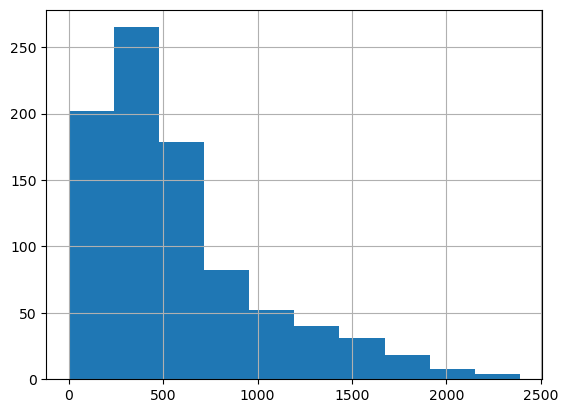

In [53]:
(affordable_housing['dist_to_metro_center'] - affordable_housing['straight_dist_to_metro_center']).hist()